# TOTVS Challange

## Imports

In [1]:
import pandas as pd
import json

## Open File

In [2]:
with open('sample.txt', 'r') as f:
    arq = f.read()

transactions = json.loads(arq)

In [3]:
amount_transactions = len(transactions)
iterator = range(amount_transactions)

amount_transactions

1635

## Get data

In [4]:
#1
complementos = [transactions[i]['complemento']['valorTotal'] for i in iterator] 
#2
items = [[item for item in transactions[i][u'dets']] for i in iterator]  # several items per transaction
#3
emits = [transactions[i][u'emit'] for i in iterator]   
#4
ides = [transactions[i]['ide'] for i in iterator]
#5
infAdic = [transactions[0][u'infAdic']for i in iterator]
#6
total = [transactions[0][u'total']['icmsTot'] for i in iterator]

## Parse Data into columns DFs

In [5]:
#1
complementos_df = pd.DataFrame(data=complementos, columns=['complementos'])

#2
items_df = pd.DataFrame(items)
items_df = items_df.stack().reset_index()
items_df.columns = ['Transaction', 'nItems', 'Product']
product_df = items_df['Product'].apply(pd.Series)['prod'].apply(pd.Series)
items_df = pd.concat([items_df, product_df], axis=1)
items_df.drop('Product', axis=1, inplace=True)
print('Items size: {}'.format(items_df.shape))

#3
emits_df = pd.DataFrame(emits)
emits_df = pd.concat([emits_df, emits_df.enderEmit.apply(pd.Series)], axis=1)
emits_df.drop('enderEmit', axis=1, inplace=True)

#4
ides_df = pd.DataFrame(ides)
ides_df.dhEmi = ides_df.dhEmi.apply(pd.Series)

#5
infAdic_df = pd.DataFrame(infAdic)

#6
total_df = pd.DataFrame(total)

Items size: (3547, 8)


## Merge data from DFs

In [6]:
for tmp_df in [complementos_df, emits_df, ides_df, infAdic_df, total_df]:
    items_df = pd.merge(items_df, tmp_df, left_on='Transaction', right_index=True)
    
print('Items size: {}'.format(items_df.shape))

Items size: (3547, 36)


## Remove columns with constant values

#### Functon pd.factorize encodes the column

In [7]:
%%time
cat_cols_const = []
for col in items_df:
    different_values_size = pd.Series(pd.factorize(items_df[col])[0]).value_counts().shape[0]
    if different_values_size < 2:
        cat_cols_const.append(col)

CPU times: user 60.7 ms, sys: 1.62 ms, total: 62.3 ms
Wall time: 64.4 ms


In [8]:
items_const_df_cat = items_df[cat_cols_const]
items_df = items_df[items_df.columns.difference(cat_cols_const)]

## Finally some clean data to work with..

In [9]:
items_df.head(2)

,Transaction,complementos,dhEmi,nItems,qCom,uCom,vProd_x,vUnCom,xProd
0,0,24.9,2016-01-05T12:01:54.000Z,0,1.000,UN,3.5,3.5,AGUA
1,0,24.9,2016-01-05T12:01:54.000Z,1,0.312,KG,21.4,68.6,BUFFET


In [10]:
items_df.columns = ['Transaction', 'Total', 'Date', 'Nth_item', 'Quantity', 'Unity', 'Value_paid', 'Value_original', 'SKU']

In [11]:
items_df.Date = pd.to_datetime(items_df.Date)
items_df.set_index('Date', inplace=True)

## Wait, no...Now we have better names, and dates

In [12]:
items_df.head(10)

,Transaction,Total,Nth_item,Quantity,Unity,Value_paid,Value_original,SKU
Date,,,,,,,,
2016-01-05 12:01:54,0,24.90,0,1.000,UN,3.50,3.5,AGUA
2016-01-05 12:01:54,0,24.90,1,0.312,KG,21.40,68.6,BUFFET
2016-01-05 12:03:52,1,92.53,0,1.218,KG,83.55,68.6,BUFFET
2016-01-05 12:03:52,1,92.53,1,2.000,UN,9.00,4.5,REFRIGERANTE
2016-01-05 12:16:40,2,57.86,0,1.000,UN,4.50,4.5,SUCO
2016-01-05 12:16:40,2,57.86,1,0.778,KG,53.37,68.6,BUFFET
2016-01-05 12:17:50,3,34.97,0,0.510,KG,34.98,68.6,BUFFET
2016-01-05 12:18:35,4,46.23,0,0.674,KG,46.23,68.6,BUFFET
2016-01-05 12:20:00,5,32.76,0,0.412,KG,28.26,68.6,BUFFET


## Looks like they don't open on sundays
### And there is a pretty beautiful weekly seasonality with peaks on wednesdays and falling to almost half of SKUs sold in the rest of the week

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


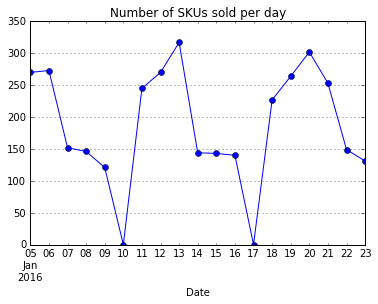

In [13]:
%pylab inline 

items_df.resample('d').count()['SKU'].plot(grid=True, marker='o')
title('Number of SKUs sold per day')

#### Yea..no sundays. And their best day is wednesday. At what hour?

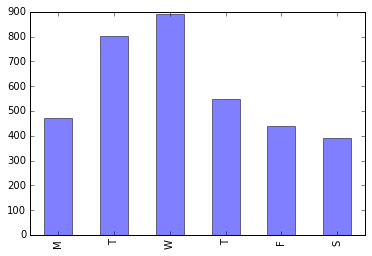

In [14]:
fig = items_df.groupby(items_df.index.weekday).count()['SKU'].plot.bar(alpha=.5)
ticks = fig.set_xticklabels(['M', 'T', 'W', 'T', 'F', 'S'])

#### Alright..Lunch time and dinner. No surprise there. Best at lunch.

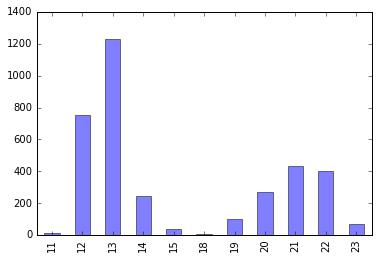

In [15]:
fig = items_df.groupby(items_df.index.hour).count()['SKU'].plot.bar(alpha=.5)

## Which items are mostly sold in the lunch/afternoon and at night?

### Look at that!! 'CHA' was replaced by 'CERVEJA' at night

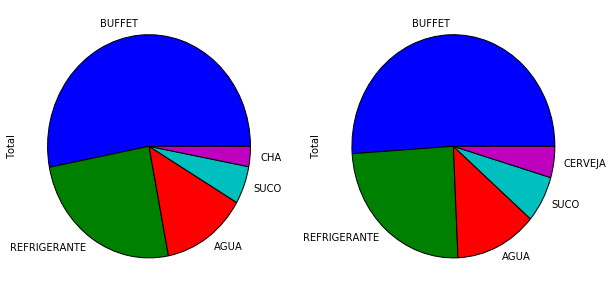

In [16]:
figsize(10,5)
lunch_df = items_df[items_df.index.hour < 18]
night_df = items_df[items_df.index.hour >= 18]

fig, ax = pyplot.subplots(1,2)

lunch_df.groupby('SKU').count()['Total'].sort_values(ascending=False).head().plot.pie(ax=ax[0])
night_df.groupby('SKU').count()['Total'].sort_values(ascending=False).head().plot.pie(ax=ax[1])

### We've analysed some patterns about time and mostly sold items. I could go on and on analysing other things like what is mostly profitable, what are they buying together with SUSHI or other stuff, but I got curious to check out what is the distribution of the Buffet kilograms!!

Transaction         1634
Total             608.91
Nth_item               7
Quantity           4.896
Unity                 KG
Value_paid        335.86
Value_original      68.6
SKU               BUFFET
dtype: object


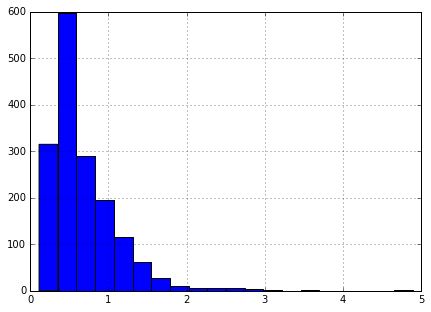

In [17]:
figsize(7,5)
items_df[items_df.SKU == 'BUFFET'].Quantity.hist(bins=20)

print(items_df[items_df.SKU == 'BUFFET'].max())

What?! Someone got a 4.896kg Buffet on the transaction 819!!! 

But it seems ok because it looks like there were many people on the table late at night. Look at their bill.

In [18]:
items_df[items_df.Transaction == 819]

,Transaction,Total,Nth_item,Quantity,Unity,Value_paid,Value_original,SKU
Date,,,,,,,,
2016-01-13 23:05:50,819,608.91,0,6.000,UN,27.00,4.5,SUCO
2016-01-13 23:05:50,819,608.91,1,9.000,UN,31.50,3.5,AGUA
2016-01-13 23:05:50,819,608.91,2,3.000,UN,14.70,4.9,SUCO
2016-01-13 23:05:50,819,608.91,3,2.000,UN,12.00,6.0,CERVEJA LATA
2016-01-13 23:05:50,819,608.91,4,1.000,UN,6.50,6.5,SUSHI ESPECIAL
2016-01-13 23:05:50,819,608.91,5,8.000,UN,78.40,9.8,CERVEJA LATA
2016-01-13 23:05:50,819,608.91,6,3.000,UN,37.50,12.5,WHISKY
2016-01-13 23:05:50,819,608.91,7,4.896,KG,335.86,68.6,BUFFET
2016-01-13 23:05:50,819,608.91,8,3.000,UN,13.50,4.5,REFRIGERANTE


# Let's get to the serious stuff
## How much will they get on the next week?

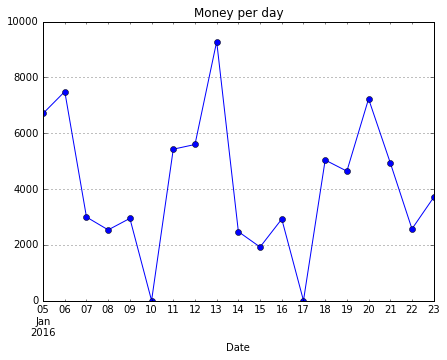

In [19]:
figsize(7,5)
title('Money per day')
items_df['Total'].drop_duplicates().resample('d').sum().fillna(0).plot(grid=True, marker='o')

## 12h time series with lag of 7days* (24h/12h) 
### They work from 11AM until 23PM

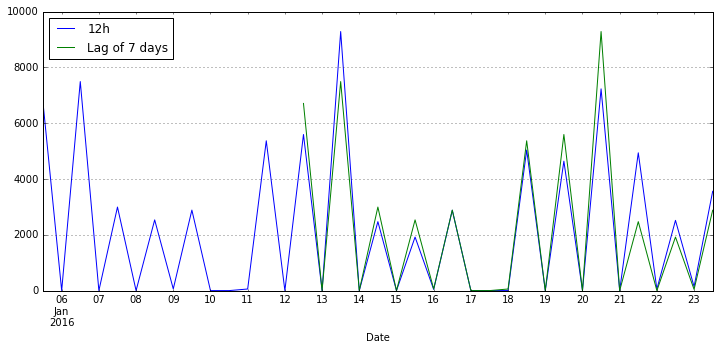

In [20]:
figsize(12, 5)
ts = items_df['Total'].drop_duplicates()

ts.resample('12h').sum().fillna(0).plot(grid=True, label='12h')
ts.resample('12h').sum().fillna(0).shift(7*2).plot(grid=True, label='Lag of 7 days')

legend(loc='best')

## This is a timeserie with a very strong weekly seasonal pattern and can be easily predicted with a lag of 7 days. Even in the 12h granularity.

In [21]:
serie = ts.resample('12h').sum().fillna(0)
serie_pred = ts.resample('12h').sum().fillna(0).shift(7*2)

In [22]:
ts_df = pd.concat([serie, serie_pred], axis=1)
ts_df.columns=['Serie', 'Serie_pred']
ts_df['AbsDiff'] = (ts_df['Serie'] - ts_df['Serie_pred']).abs()
ts_df['Contribution'] = ts_df['AbsDiff'] / ts_df['Serie'].sum()

## Final result with the WMAPE metric

In [23]:
print('{0:.2f}%'.format(100*ts_df.fillna(0)['Contribution'].sum()))

14.49%


In [24]:
pd.DataFrame(ts_df.dropna()['Contribution']).style.format('{0:.2f}%')